# Sense Reconstruction

This notebook reproduces experiments with SENSE reconstruction described in [Accelerating Non-Cartesian MRI Reconstruction Convergence using k-space Preconditioning](https://arxiv.org/abs/1902.09657).

In [1]:
%matplotlib notebook

import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import numpy as np

try:
    import mkl
    mkl.set_num_threads(1)
except:
    pass

## Set parameters and load dataset

In [2]:
max_iter = 30
lamda = 0.01

ksp_file = 'data/brain/ksp.npy'
coord_file = 'data/brain/coord.npy'

# Choose computing device.
# Device(-1) specifies CPU, while others specify GPUs.
# GPU requires installing cupy.
try:
    device = sp.Device(0)
except:
    device = sp.Device(-1)

xp = device.xp
device.use()

# Load datasets.
ksp = xp.load(ksp_file)
coord = xp.load(coord_file)

## Estimate sensitivity maps using JSENSE

Here we use [JSENSE](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21245) to estimate sensitivity maps.

In [3]:
mps = mr.app.JsenseRecon(ksp, coord=coord, device=device).run()

## CG

<IPython.core.display.Javascript object>


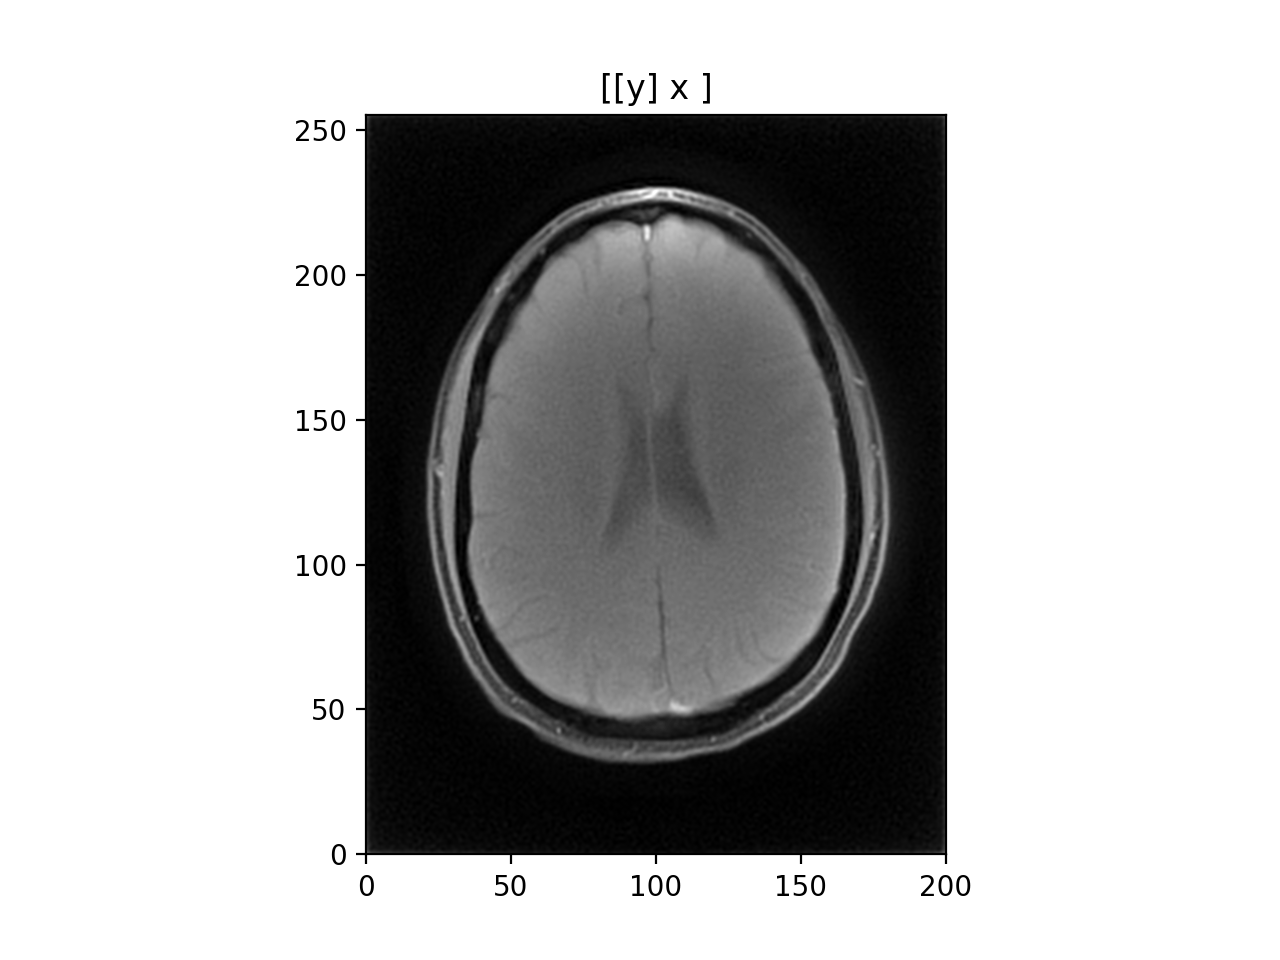

In [4]:
cg_app = mr.app.SenseRecon(
    ksp, mps, coord=coord, device=device, lamda=lamda,
    max_iter=max_iter, save_objective_values=True)
cg_img = cg_app.run()

pl.ImagePlot(cg_img)

## CG with circulant preconditioner

<IPython.core.display.Javascript object>


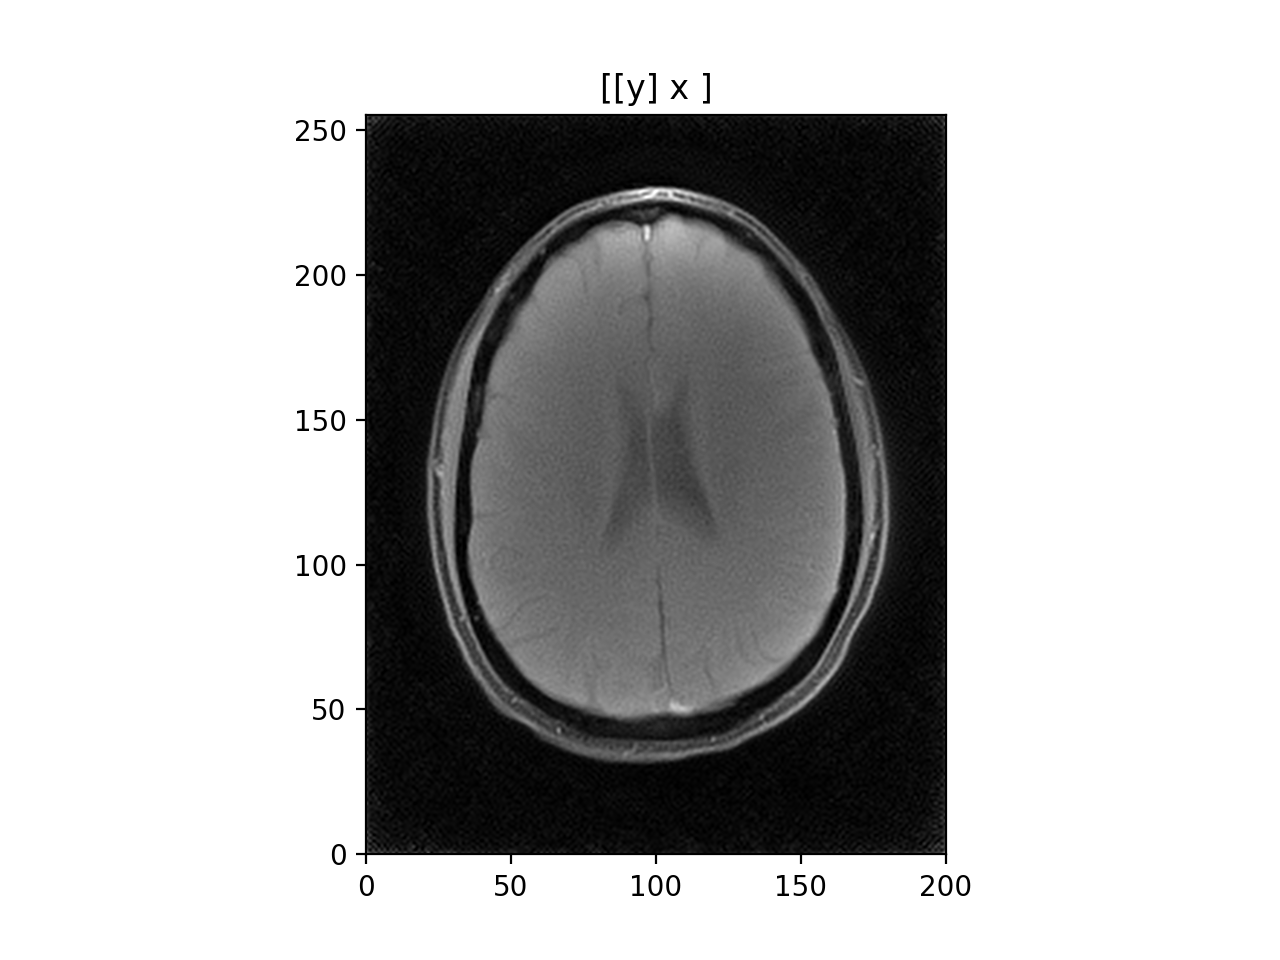

In [5]:
circ_precond = mr.circulant_precond(mps, coord=coord, device=device, lamda=lamda)

# Put into linear operator form.
img_shape = mps.shape[1:]
D = sp.linop.Multiply(img_shape, circ_precond)
P = sp.linop.IFFT(img_shape) * D * sp.linop.FFT(img_shape)

cgc_app = mr.app.SenseRecon(
    ksp, mps, coord=coord, device=device, lamda=lamda, P=P,
    max_iter=max_iter, save_objective_values=True)
cgc_img = cgc_app.run()

pl.ImagePlot(cgc_img)

## PDHG

<IPython.core.display.Javascript object>


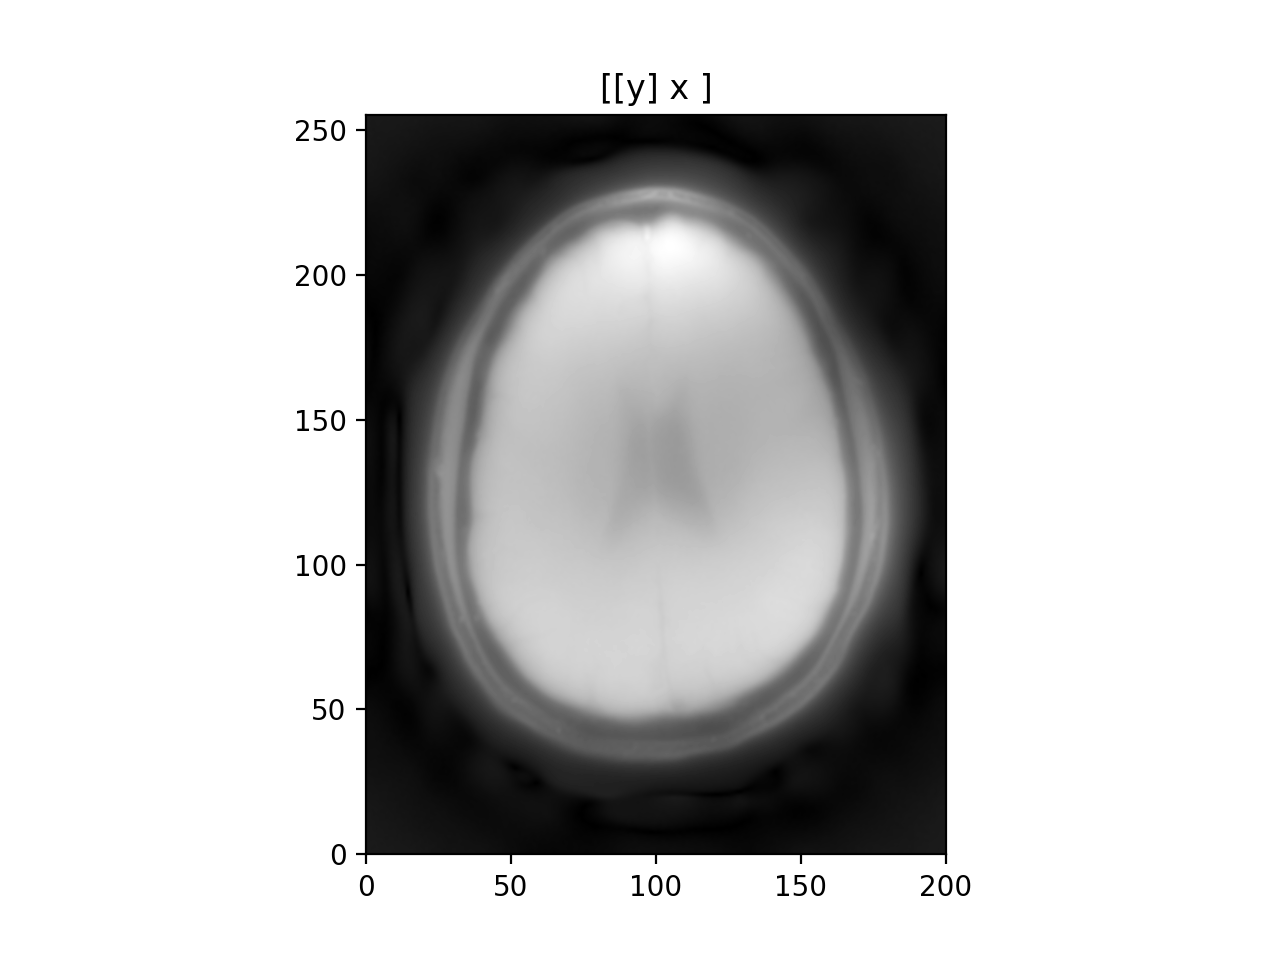

In [6]:
pdhg_app = mr.app.SenseRecon(
    ksp, mps, coord=coord, max_iter=max_iter, lamda=lamda,
    solver='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_img = pdhg_app.run()

pl.ImagePlot(pdhg_img)

## PDHG with Pipe-Menon density compensation

<IPython.core.display.Javascript object>


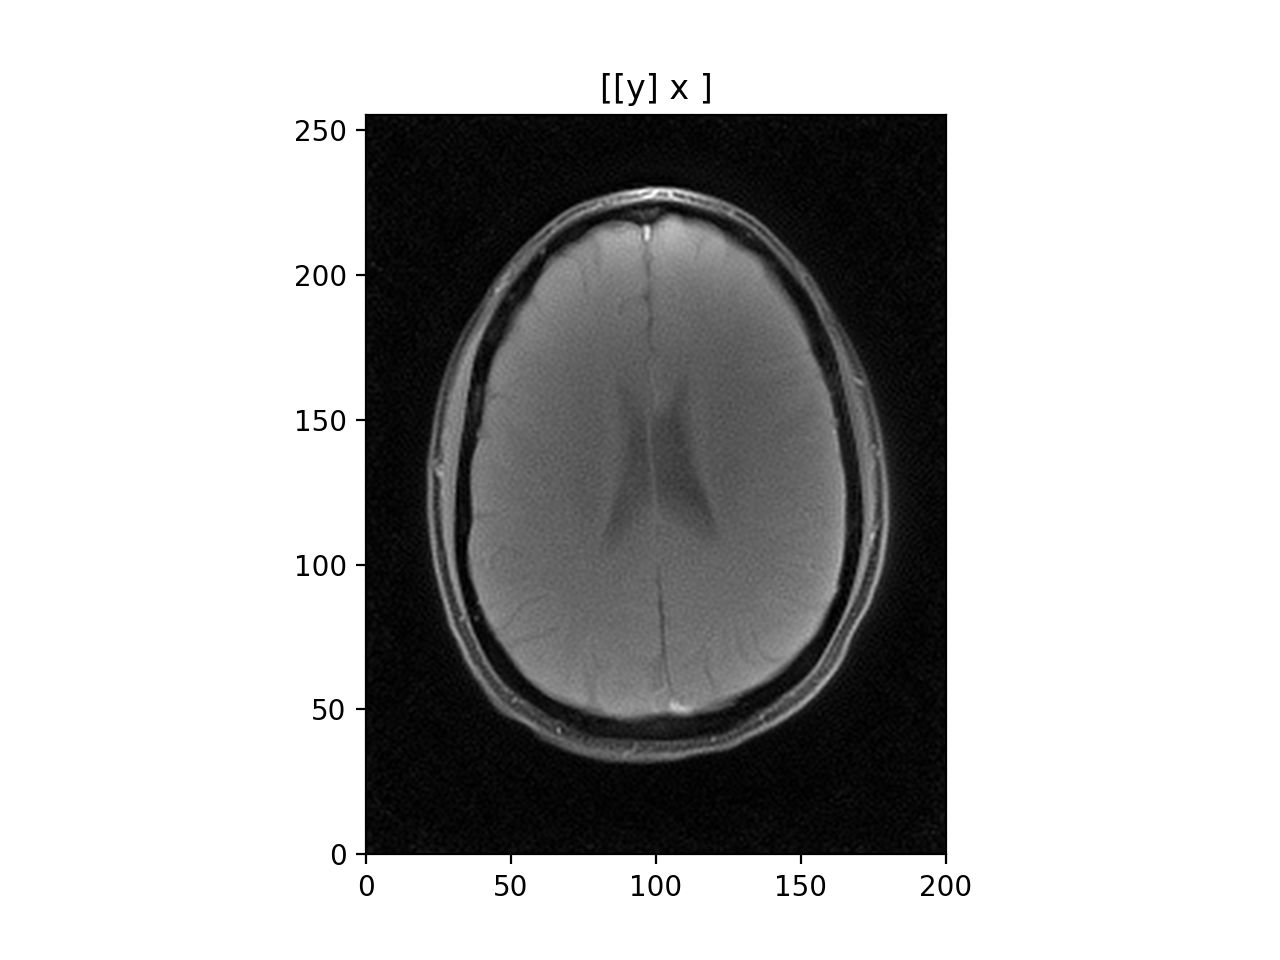

In [7]:
# Compute dcf
p = mr.pipe_menon_dcf(coord, device=device)

pdhg_dcf_app = mr.app.SenseRecon(
    ksp, mps, coord=coord, sigma=p, max_iter=max_iter, lamda=lamda,
    solver='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_dcf_img = pdhg_dcf_app.run()

pl.ImagePlot(pdhg_dcf_img)

## PDHG with single-channel preconditioner

<IPython.core.display.Javascript object>


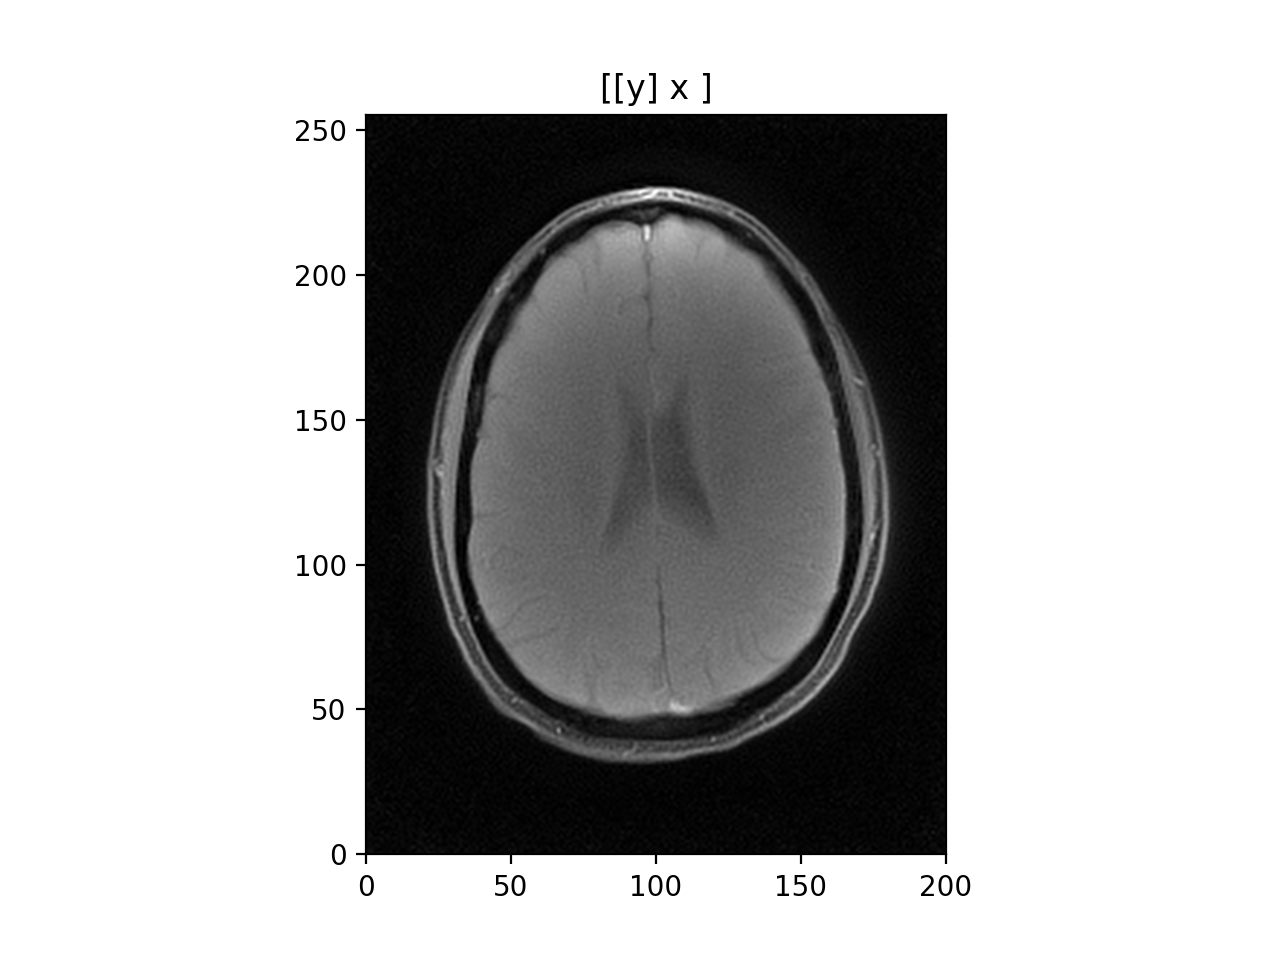

In [8]:
# Compute preconditioner
ones = np.ones_like(mps)
ones /= len(mps)**0.5
p = mr.kspace_precond(ones, coord=coord, device=device, lamda=lamda)

pdhg_sc_app = mr.app.SenseRecon(
    ksp, mps, coord=coord, sigma=p, max_iter=max_iter, lamda=lamda,
    solver='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_sc_img = pdhg_sc_app.run()

pl.ImagePlot(pdhg_sc_img)

## PDHG with multi-channel preconditioner

<IPython.core.display.Javascript object>


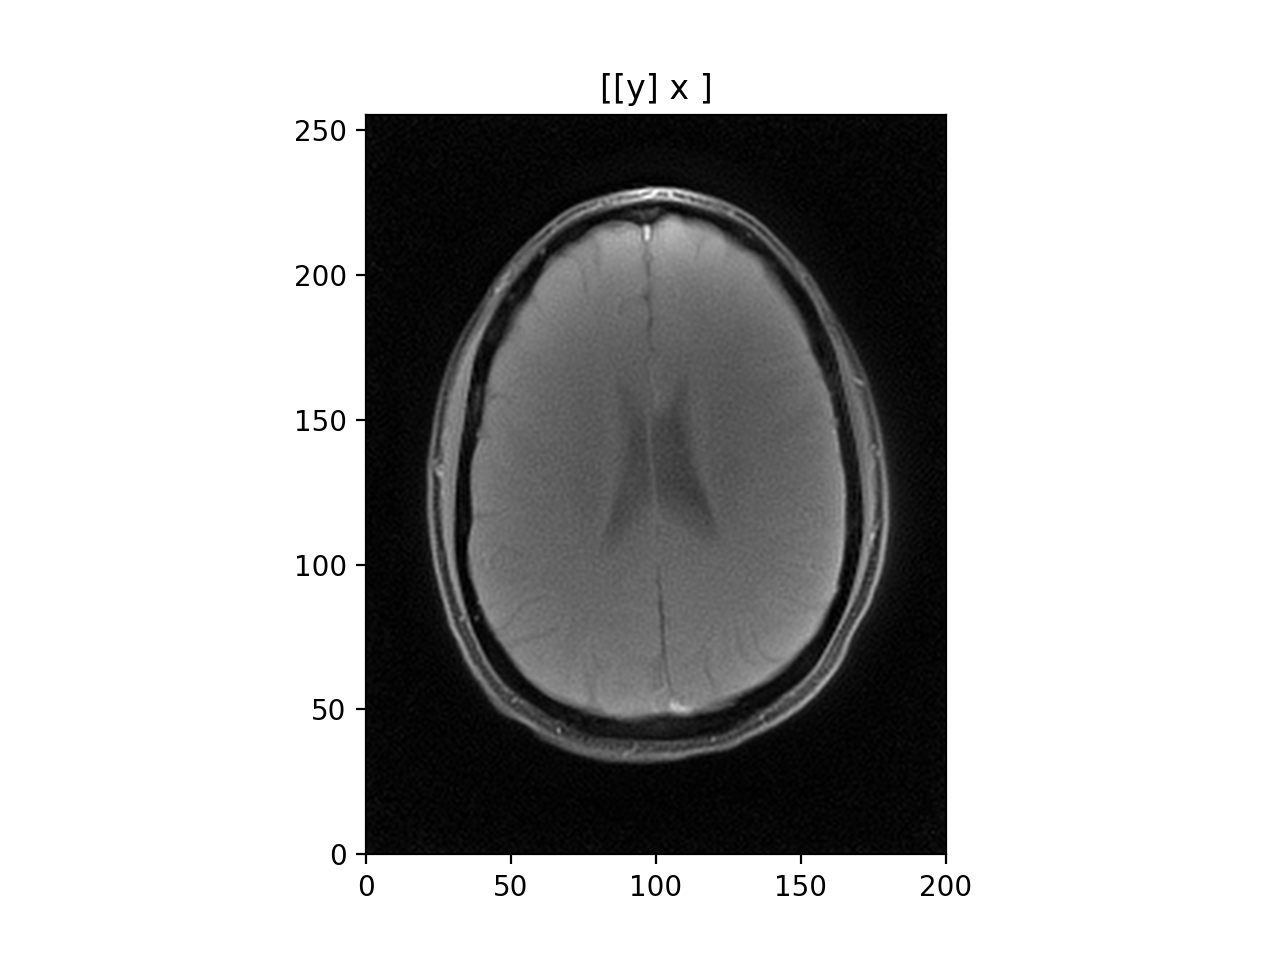

In [9]:
# Compute preconditioner
p = mr.kspace_precond(mps, coord=coord, device=device, lamda=lamda)

pdhg_mc_app = mr.app.SenseRecon(
    ksp, mps, coord=coord, sigma=p, max_iter=max_iter, lamda=lamda,
    solver='PrimalDualHybridGradient', device=device, save_objective_values=True)
pdhg_mc_img = pdhg_mc_app.run()

pl.ImagePlot(pdhg_mc_img)

## Convergence curves

<IPython.core.display.Javascript object>


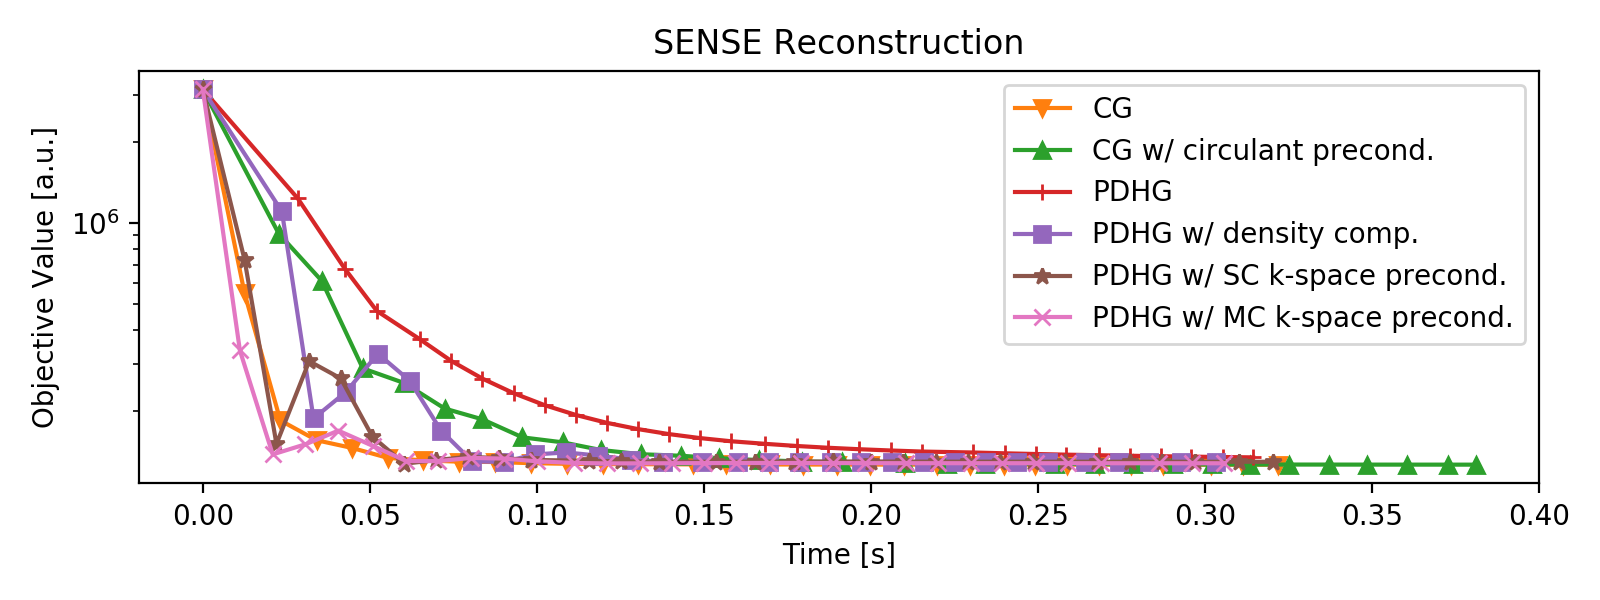

In [10]:
plt.figure(figsize=(8, 3))
plt.semilogy(cg_app.time, cg_app.objective_values,
               marker='v', color='C1')
plt.semilogy(cgc_app.time, cgc_app.objective_values,
               marker='^', color='C2')
plt.semilogy(pdhg_app.time, pdhg_app.objective_values,
               marker='+', color='C3')
plt.semilogy(pdhg_dcf_app.time, pdhg_dcf_app.objective_values,
               marker='s', color='C4')
plt.semilogy(pdhg_sc_app.time, pdhg_sc_app.objective_values,
               marker='*', color='C5')
plt.semilogy(pdhg_mc_app.time, pdhg_mc_app.objective_values,
               marker='x', color='C6')
plt.legend(['CG',
            'CG w/ circulant precond.',
            'PDHG',
            'PDHG w/ density comp.',
            'PDHG w/ SC k-space precond.',
            'PDHG w/ MC k-space precond.'])
plt.ylabel('Objective Value [a.u.]')
plt.xlabel('Time [s]')
plt.title(r"SENSE Reconstruction")
plt.tight_layout()
plt.show()